In [88]:
import numpy as np
import pandas as pd
from astropy.io import fits
import requests
from PIL import Image
import io
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

def evaluate_model(model, val_loader, device):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Get unique classes actually present in the data
    unique_classes = np.unique(all_labels)
    target_names = [f'DoR Group {i}' for i in unique_classes]
    
    return classification_report(all_labels, all_preds, 
                               target_names=target_names)


def get_sdss_image_url(plate, mjd, fiber, scale=0.4, width=64, height=64):
    """
    Constructs URL for SDSS image cutout using Legacy Survey
    """
    try:
        # Get RA/DEC from your local FITS files
        fits_filename = f"fits_shortlist/spec-{plate:04d}-{mjd}-{fiber:04d}.fits"
        
        try:
            with fits.open(fits_filename) as hdul:
                ra = hdul[0].header['PLUG_RA']
                dec = hdul[0].header['PLUG_DEC']
                # print(f"Found coordinates for {fits_filename}: RA={ra}, DEC={dec}")
        except Exception as e:
            print(f"Error reading FITS file {fits_filename}: {str(e)}")
            return None
            
        # Use Legacy Survey instead - more reliable
        pixel_scale = 0.262  # arcsec/pixel
        size = int(width * scale / pixel_scale)  # convert to Legacy Survey pixel size
        
        base_url = "https://www.legacysurvey.org/viewer/jpeg-cutout"
        params = {
            'ra': ra,
            'dec': dec,
            'width': size,
            'height': size,
            'layer': 'sdss',
            'pixscale': pixel_scale
        }
        
        url = f"{base_url}?"
        url += "&".join([f"{key}={value}" for key, value in params.items()])
        
        # print(f"Generated URL: {url}")
        
        return url, ra, dec
        
    except Exception as e:
        print(f"Error processing {plate}-{mjd}-{fiber}: {str(e)}")
        return None    
    
def download_image(url, output_path, max_retries=3):
    """Downloads image from URL and saves to specified path"""
    for attempt in range(max_retries):
        try:
            response = requests.get(url, timeout=30)
            if response.status_code == 200:
                try:
                    img = Image.open(io.BytesIO(response.content))
                    img = img.convert('RGB')
                    img.save(output_path)
                    return True
                except Exception as e:
                    print(f"Error saving image: {str(e)}")
                    if attempt == max_retries - 1:
                        return False
                    time.sleep(1)
            else:
                print(f"Failed download (attempt {attempt + 1}): Status {response.status_code}")
                if attempt == max_retries - 1:
                    return False
                time.sleep(1)
        except Exception as e:
            print(f"Error downloading (attempt {attempt + 1}): {str(e)}")
            if attempt == max_retries - 1:
                return False
            time.sleep(1)
    return False

def prepare_galaxy_images(galaxies_df, output_dir='galaxy_images', image_size=64):
    """
    Download and prepare SDSS images for a set of galaxies
    
    Parameters:
    -----------
    galaxies_df : pandas.DataFrame
        DataFrame containing plate, mjd, fiber columns
    output_dir : str
        Directory to save images
    image_size : int
        Size of image cutouts in pixels
    
    Returns:
    --------
    pandas.DataFrame
        Original dataframe with additional columns for image paths and RA/DEC
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Lists to store results
    image_paths = []
    ras = []
    decs = []
    success = []
    
    def process_galaxy(row):
        plate = int(row['plate'])
        mjd = int(row['mjd'])
        fiber = int(row['fiberid'])
        
        # Generate unique filename
        filename = f"spec-{plate:04d}-{mjd}-{fiber:04d}.jpg"
        output_path = os.path.join(output_dir, filename)
        
        # Get image URL and coordinates
        result = get_sdss_image_url(plate, mjd, fiber, 
                                  width=image_size, 
                                  height=image_size)
        
        if result is None:
            return (output_path, None, None, False)
            
        url, ra, dec = result
        
        # Download image
        success = download_image(url, output_path)
        
        return (output_path, ra, dec, success)
    
    # Process galaxies in parallel
    print("Downloading galaxy images...")
    with ThreadPoolExecutor(max_workers=10) as executor:
        results = list(tqdm(executor.map(process_galaxy, 
                                       [row for _, row in galaxies_df.iterrows()]), 
                          total=len(galaxies_df)))
    
    # Unpack results
    image_paths, ras, decs, success = zip(*results)
    
    # Add columns to dataframe
    galaxies_df['image_path'] = image_paths
    galaxies_df['ra'] = ras
    galaxies_df['dec'] = decs
    galaxies_df['image_downloaded'] = success
    
    print(f"\nDownloaded {sum(success)} images successfully")
    print(f"Failed to download {len(success) - sum(success)} images")
    
    return galaxies_df

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

class GalaxyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

class GalaxyClassifierCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(GalaxyClassifierCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.adaptive_pool(x)
        x = self.fc_layers(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs=10, device='cuda', patience=5):
    """
    Train the CNN model
    """
    model = model.to(device)
    best_val_acc = 0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * train_correct / train_total
        train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        val_loss = val_loss / len(val_loader)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
    
    return history

def prepare_data_loaders(image_paths, labels, batch_size=32, test_size=0.2):
    """
    Prepare train and validation data loaders
    """
    # Define transformations
    transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),  # Galaxies are orientation-invariant
    transforms.RandomRotation(360),        # Full rotation
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.1
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
    ])
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        image_paths, labels, test_size=test_size, random_state=42)
    
    # Create datasets
    train_dataset = GalaxyDataset(X_train, y_train, transform=transform)
    val_dataset = GalaxyDataset(X_val, y_val, transform=transform)
    
    # Create data loaders with num_workers=0
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                            shuffle=True, num_workers=0)  # Changed from 4 to 0
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                          shuffle=False, num_workers=0)   # Changed from 4 to 0
    
    return train_loader, val_loader

In [90]:
df = pd.read_csv('data/E-INSPIRE_I_master_catalogue.csv')  # Should have 'plate', 'mjd', 'fiberid' columns

def create_dor_labels(dor_value):
    if dor_value < 0.3:
        return 0
    elif dor_value < 0.6:
        return 1
    else:
        return 2

# Modify the label creation
df['relic_label'] = df['DoR'].apply(lambda x: 0 if x < 0.3 else (1 if x < 0.6 else 2))

print(df['relic_label'].value_counts())

relic_label
1    293
2     81
0     56
Name: count, dtype: int64


Attempting to download 430 galaxy images...


 61%|██████▏   | 264/430 [00:26<00:11, 14.33it/s]

Failed download (attempt 1): Status 429


 67%|██████▋   | 287/430 [00:28<00:09, 14.64it/s]

Failed download (attempt 1): Status 429
Failed download (attempt 1): Status 429


 70%|███████   | 302/430 [00:30<00:12, 10.07it/s]

Failed download (attempt 1): Status 429
Failed download (attempt 1): Status 429
Failed download (attempt 1): Status 429
Failed download (attempt 1): Status 429
Failed download (attempt 1): Status 429


100%|██████████| 430/430 [00:45<00:00,  9.55it/s]



Downloaded 430 images successfully
Failed to download 0 images

Download Summary:
--------------------------------------------------
Total galaxies: 430
Successfully downloaded: 430
Failed downloads: 0

First few successful downloads:
   plate    mjd  fiberid                              image_path
0   4405  55854      591  galaxy_images/spec-4405-55854-0591.jpg
1   1342  52793      503  galaxy_images/spec-1342-52793-0503.jpg
2   2775  54535      128  galaxy_images/spec-2775-54535-0128.jpg
3    485  51909      432  galaxy_images/spec-0485-51909-0432.jpg
4   1781  53297      341  galaxy_images/spec-1781-53297-0341.jpg

Class Distribution:
relic_label
1    293
2     81
0     56
Name: count, dtype: int64

Percentage Distribution:
relic_label
1    68.139535
2    18.837209
0    13.023256
Name: proportion, dtype: float64

Number of usable images: 430
Label distribution in full dataset:
relic_label
1    293
2     81
0     56
Name: count, dtype: int64

Label distribution in valid data:
relic_

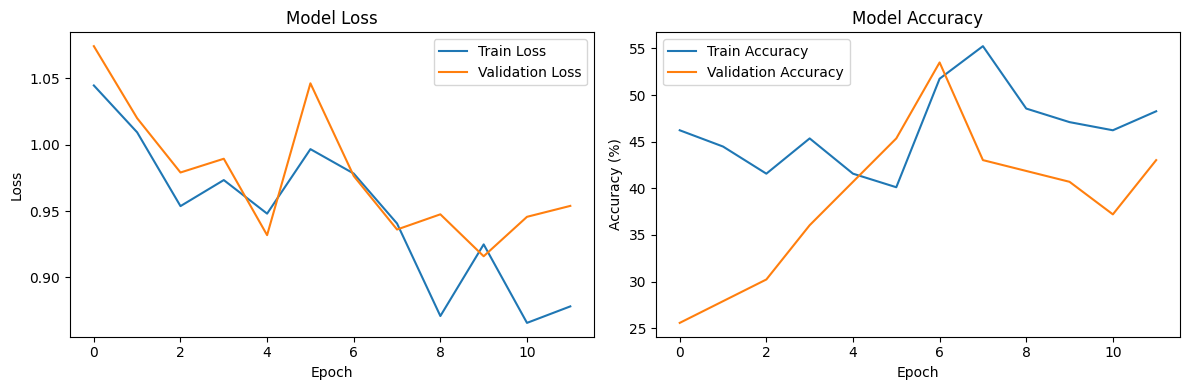


Classification Report:
              precision    recall  f1-score   support

 DoR Group 0       0.35      0.88      0.50        16
 DoR Group 1       0.74      0.58      0.65        50
 DoR Group 2       0.57      0.20      0.30        20

    accuracy                           0.55        86
   macro avg       0.56      0.55      0.48        86
weighted avg       0.63      0.55      0.54        86



In [91]:
# Before running prepare_galaxy_images
import os
import shutil
import warnings
warnings.filterwarnings('ignore')

# Clear existing downloaded images if any
if os.path.exists('galaxy_images'):
    shutil.rmtree('galaxy_images')
os.makedirs('galaxy_images')

print(f"Attempting to download {len(df)} galaxy images...")
df_with_images = prepare_galaxy_images(df, output_dir='galaxy_images', image_size=64)

print("\nDownload Summary:")
print("-" * 50)
print(f"Total galaxies: {len(df)}")
print(f"Successfully downloaded: {df_with_images['image_downloaded'].sum()}")
print(f"Failed downloads: {len(df) - df_with_images['image_downloaded'].sum()}")

# Save successful downloads info
successful = df_with_images[df_with_images['image_downloaded']]
print("\nFirst few successful downloads:")
print(successful[['plate', 'mjd', 'fiberid', 'image_path']].head())

# After downloading images, let's check our class distribution
print("\nClass Distribution:")
print(df_with_images['relic_label'].value_counts())
print("\nPercentage Distribution:")
print(df_with_images['relic_label'].value_counts(normalize=True) * 100)

# Only use images that were successfully downloaded
valid_data = df_with_images[df_with_images['image_downloaded']]
print(f"\nNumber of usable images: {len(valid_data)}")


# After creating the labels
print("Label distribution in full dataset:")
print(df['relic_label'].value_counts())

print("\nLabel distribution in valid data:")
print(valid_data['relic_label'].value_counts())


if len(valid_data) == 0:
    raise RuntimeError("No valid images found. Check the download process.")

# Create data loaders
train_loader, val_loader = prepare_data_loaders(
    valid_data['image_path'].values,
    valid_data['relic_label'].values,
    batch_size=32
)

# Initialize model and training parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")

# Add class weights to handle imbalance
existing_classes = sorted(df['relic_label'].unique())
class_counts = valid_data['relic_label'].value_counts()
weights = torch.FloatTensor([
    1/(class_counts[0] + 1e-5),
    1/(class_counts[1] + 1e-5),
    1/(class_counts[2] + 1e-5)
])
weights = weights / weights.sum()

model = GalaxyClassifierCNN(num_classes=3)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, 
                     num_epochs=20, device=device)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Load the best model and evaluate it
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Print classification report
print("\nClassification Report:")
print(evaluate_model(model, val_loader, device))

In [92]:
print("Total galaxies in DataFrame:", len(df))
print("Total downloaded images:", len(os.listdir('galaxy_images')) if os.path.exists('galaxy_images') else 0)

Total galaxies in DataFrame: 430
Total downloaded images: 430
